In [24]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get the old and new data directories
list_of_commits = list(Path("../../logs/performance/git_heads").glob("*/"))

list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:2]
list_of_files_new = list(Path(list_of_commits[0] / "all").glob("*.csv"))
list_of_files_old = list(Path(list_of_commits[1] / "all").glob("*.csv"))
list_of_files_new_profiling = list(Path(list_of_commits[0] / "profiling").glob("*.csv"))
list_of_files_old_profiling = list(Path(list_of_commits[1] / "profiling").glob("*.csv"))

latest_file_new = max(list_of_files_new, key=os.path.getctime)
latest_file_old = max(list_of_files_old, key=os.path.getctime)


latest_file_new_profiling = max(list_of_files_new_profiling, key=os.path.getctime)
latest_file_old_profiling = max(list_of_files_old_profiling, key=os.path.getctime)

df_latest_new = pd.read_csv(latest_file_new)
df_latest_old = pd.read_csv(latest_file_old)

# format: timestamp,category,test_name,query,scenario,execution_time,results_consistent,fainder_mode,num_results,ids,num_terms,id_str

df_latest_new_profiling = pd.read_csv(latest_file_new_profiling)
df_latest_old_profiling = pd.read_csv(latest_file_old_profiling)
# format: timestamp,category,test_name,query,scenario,fainder_mode,ncalls,tottime,percall_tottime,cumtime,percall_cumtime,function_info


# assert num_results with the same test_name, query, scenario, fainder_mode
def compare_num_results(df1, df2):
    for i in range(len(df1)):
        test_name = df1.iloc[i]["test_name"]
        query = df1.iloc[i]["query"]
        scenario = df1.iloc[i]["scenario"]
        fainder_mode = df1.iloc[i]["fainder_mode"]
        num_results_1 = df1.iloc[i]["num_results"]
        num_results_2 = df2[
            (df2["test_name"] == test_name)
            & (df2["query"] == query)
            & (df2["scenario"] == scenario)
            & (df2["fainder_mode"] == fainder_mode)
        ]["num_results"].values[0]
        if num_results_1 != num_results_2:
            print(
                f"num_results mismatch: {test_name}, {query}, {scenario}, {fainder_mode}: {num_results_1} vs {num_results_2}"
            )
            return False
    return True

compare_num_results(df_latest_new, df_latest_old)



num_results mismatch: percentile_ge_0_0, col(pp(0.5;ge;100)), simple, full_precision: 54507 vs 74645


False

/tmp/ipykernel_9841/2754566426.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


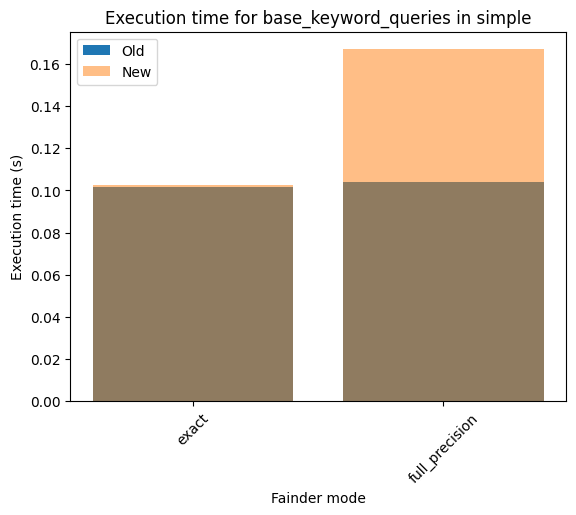

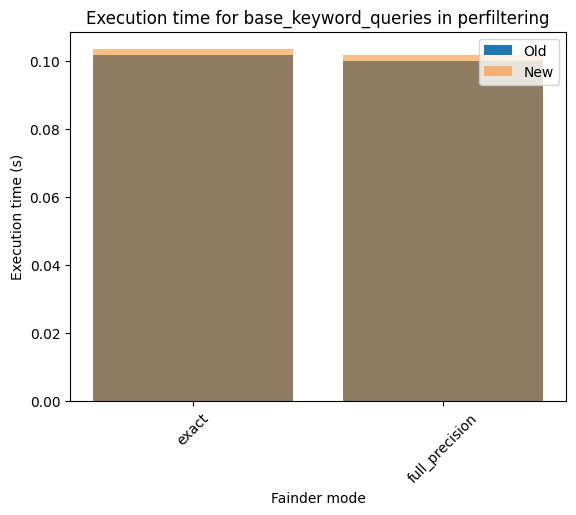

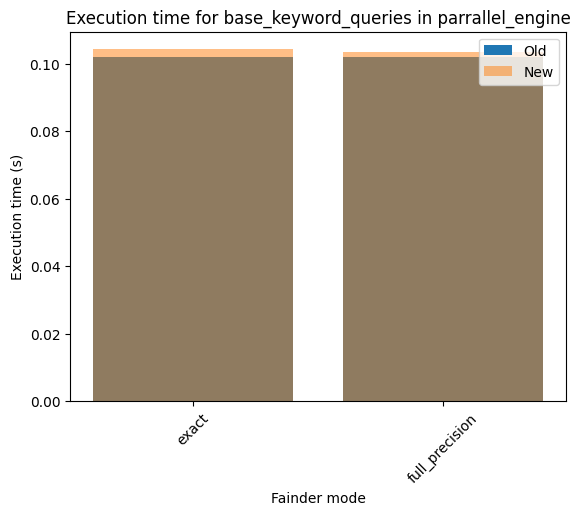

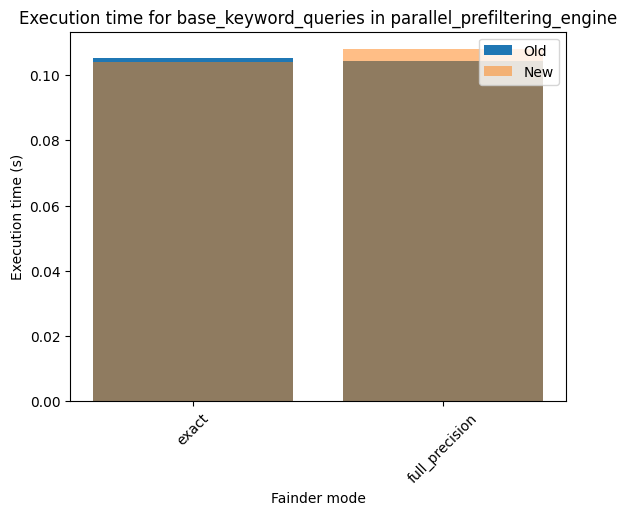

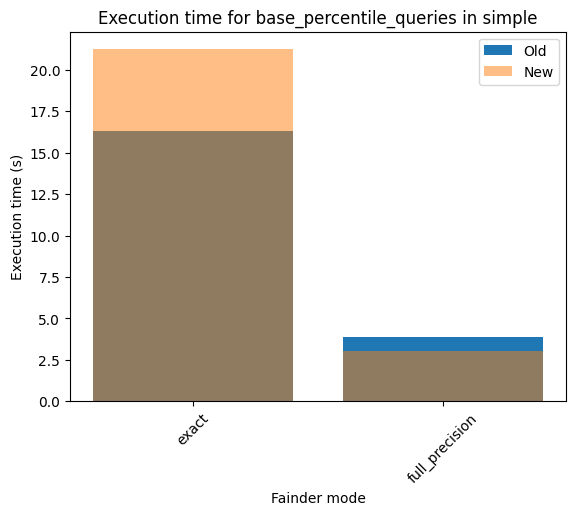

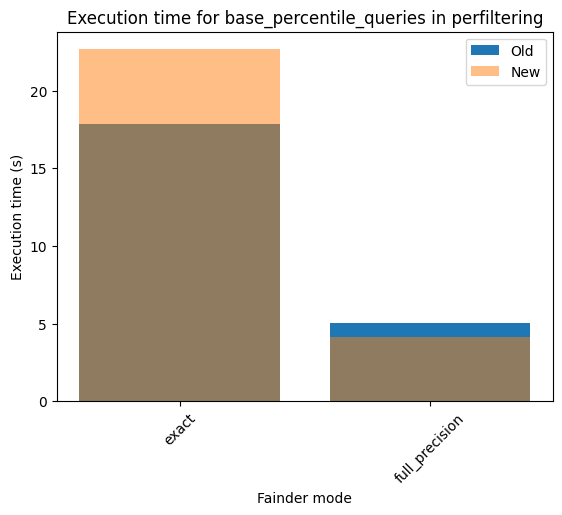

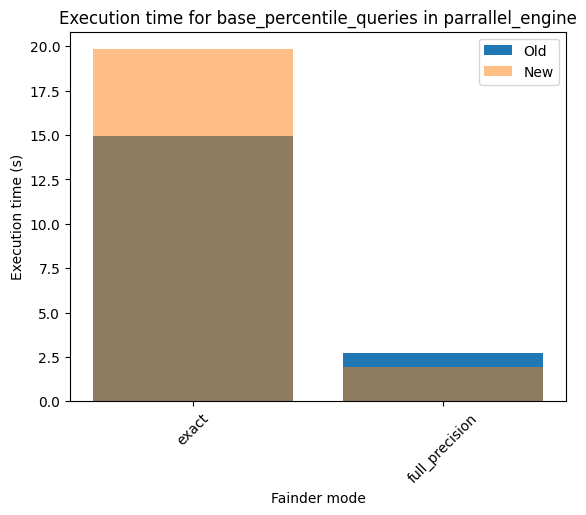

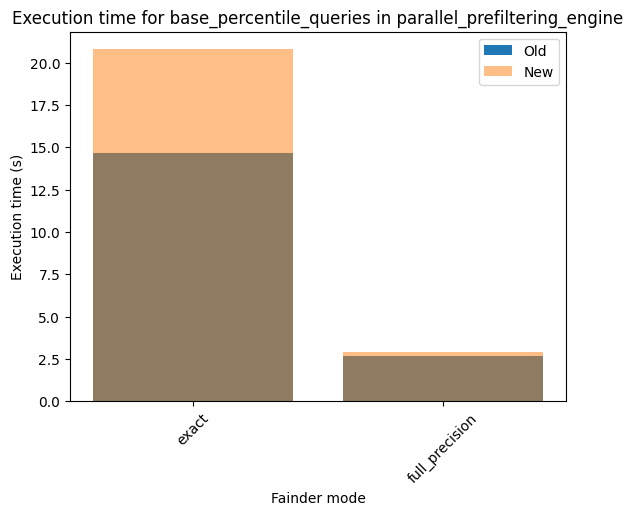

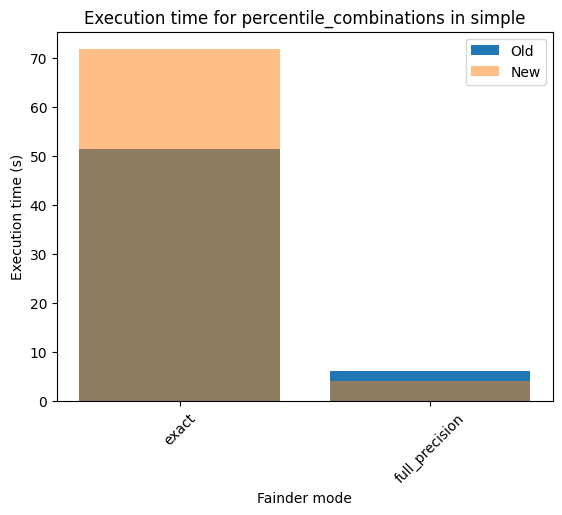

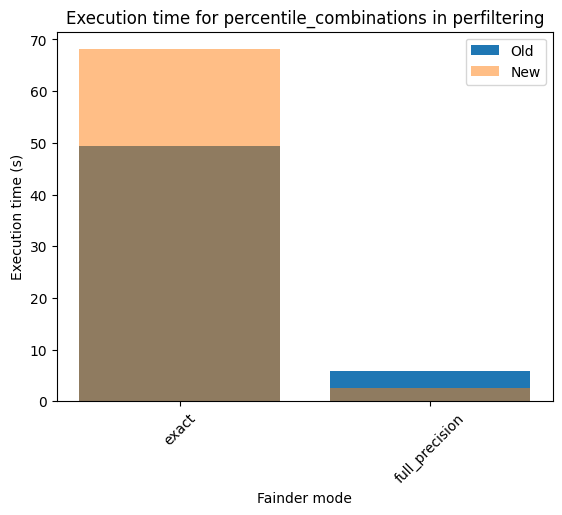

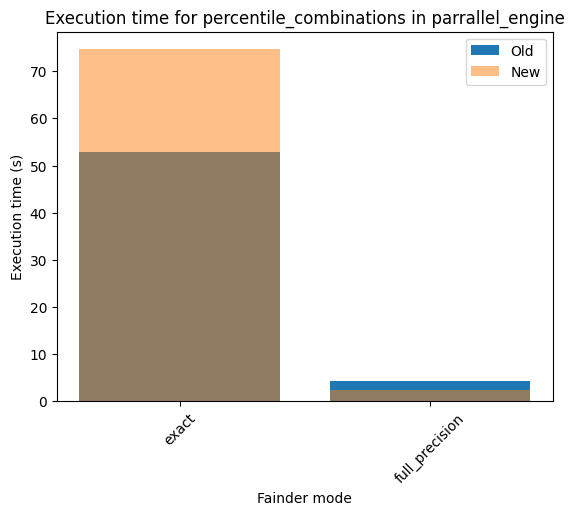

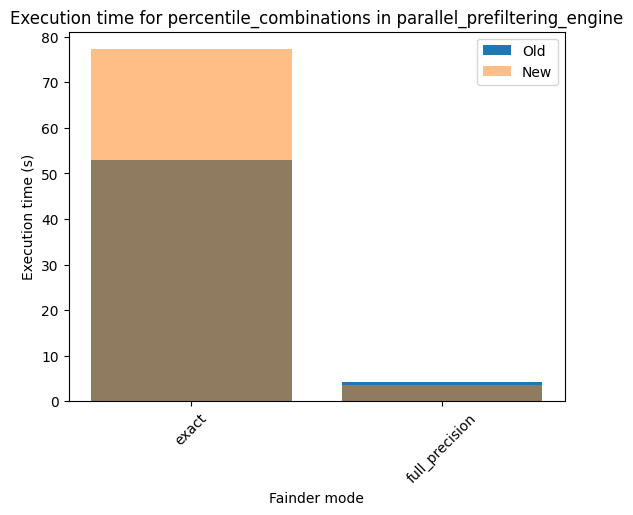

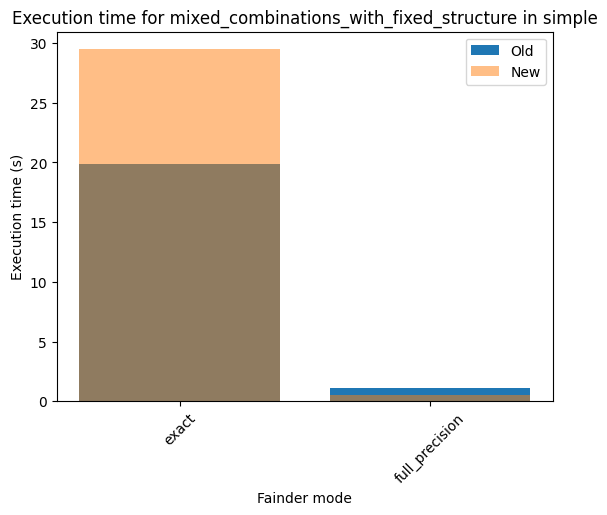

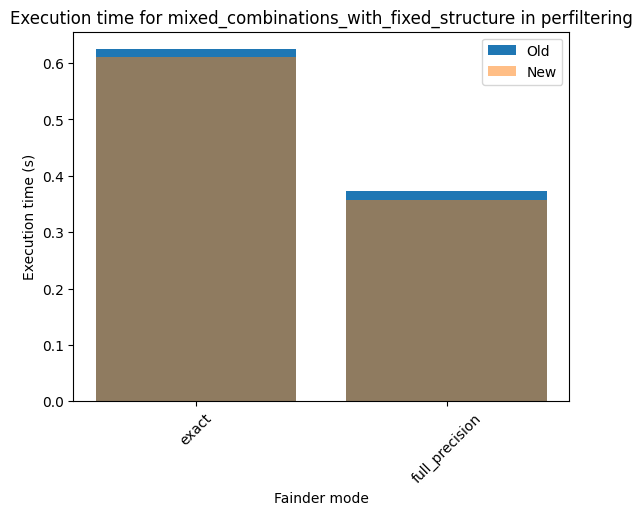

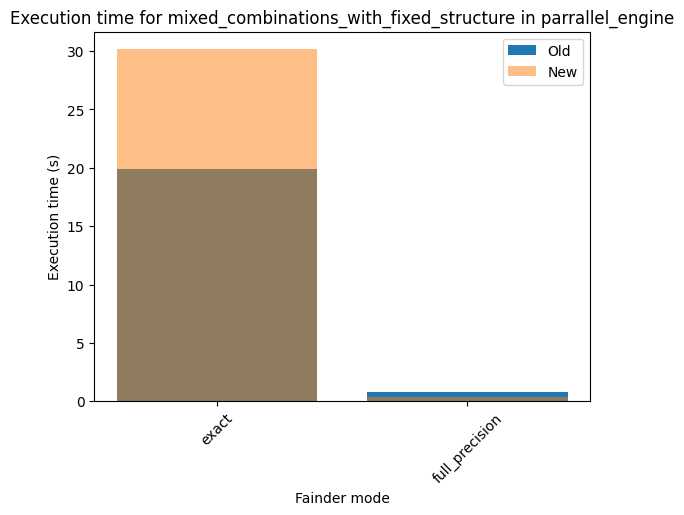

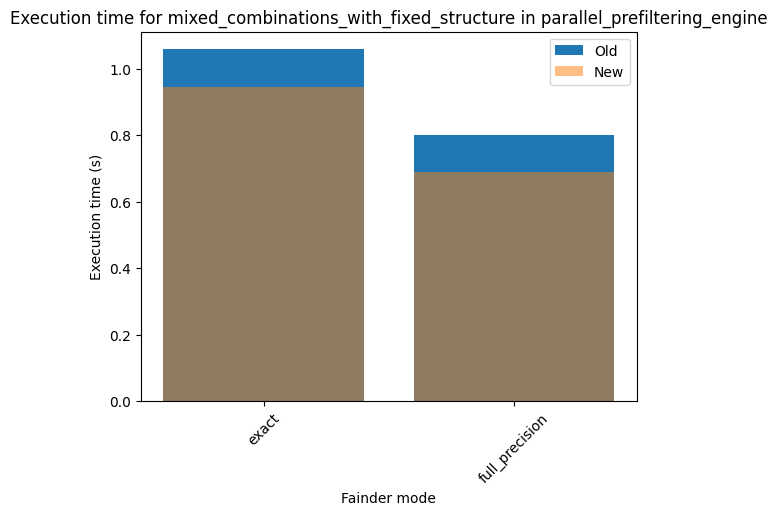

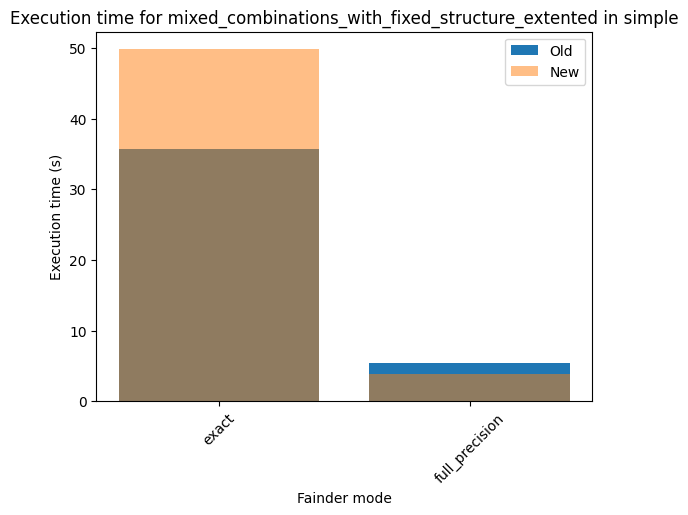

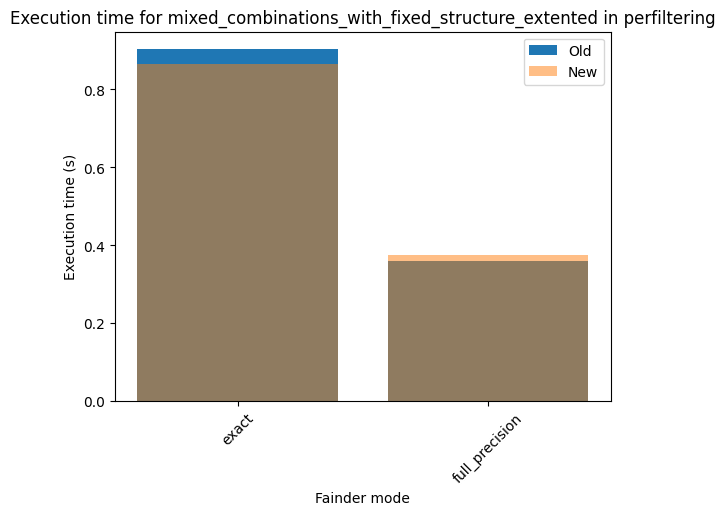

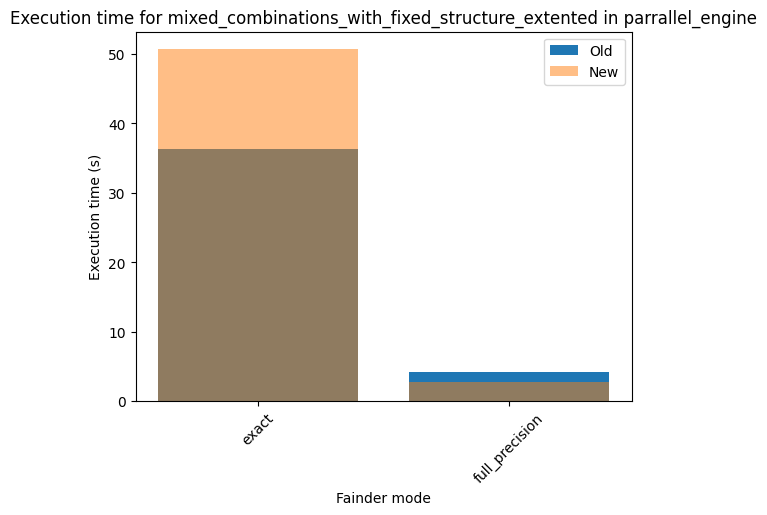

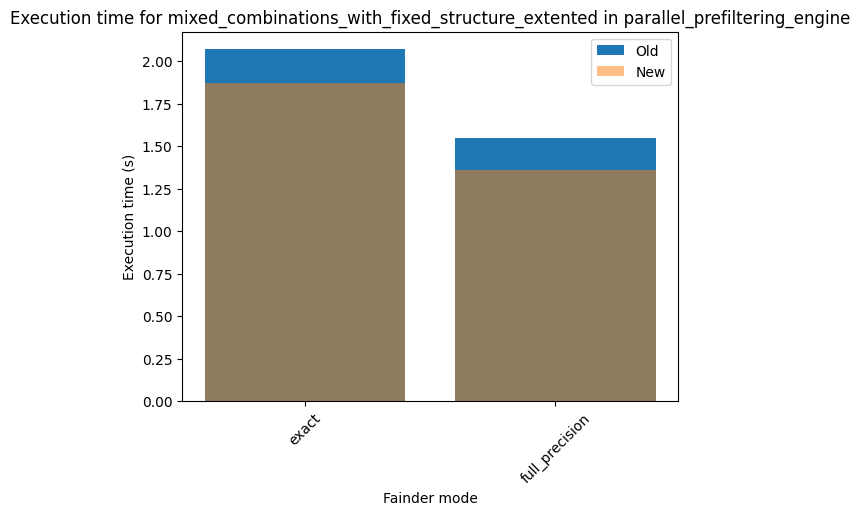

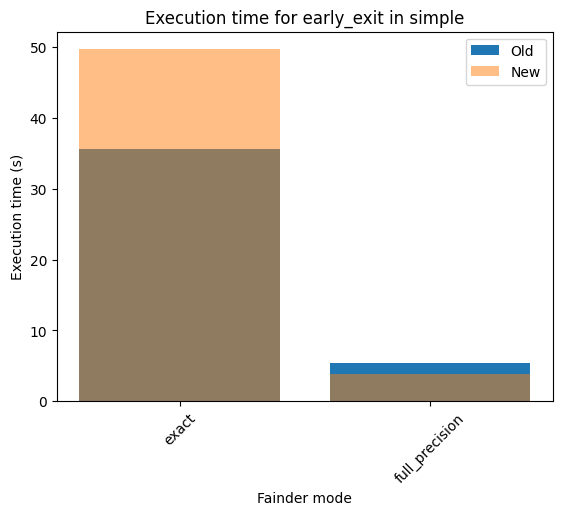

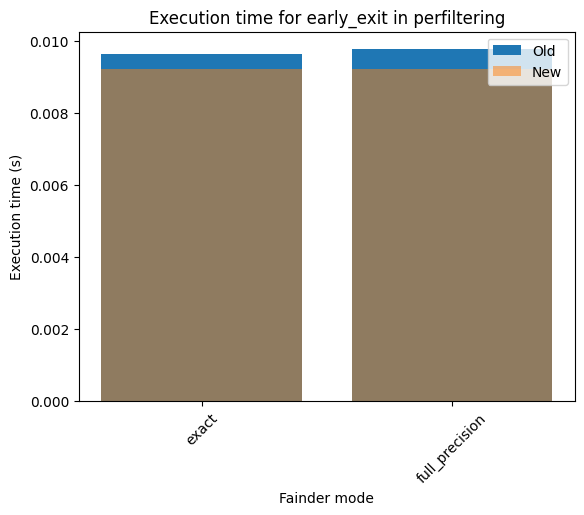

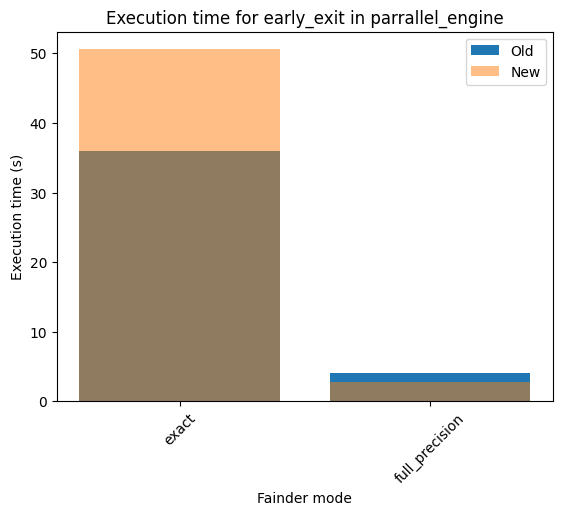

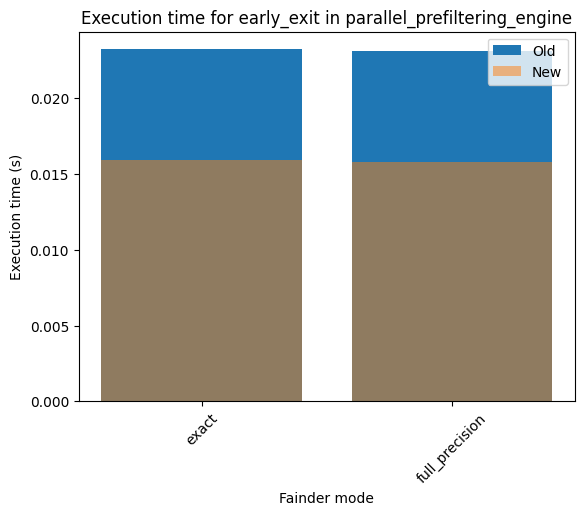

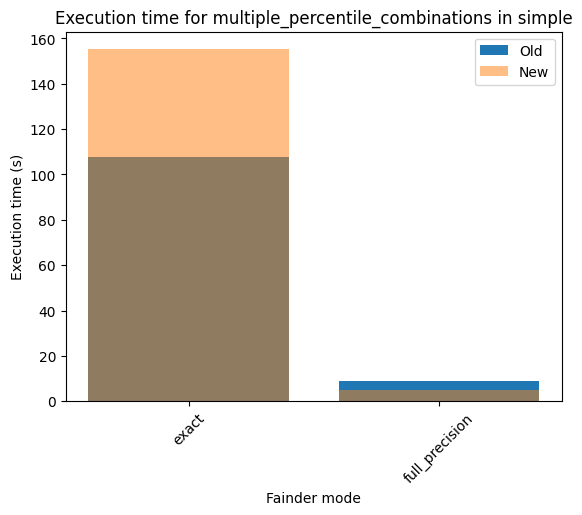

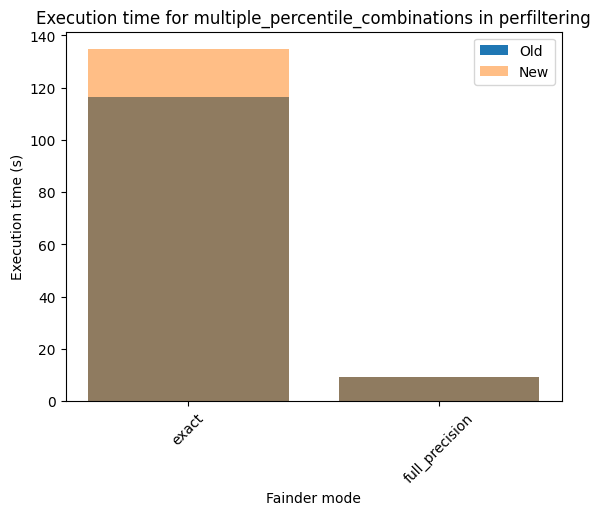

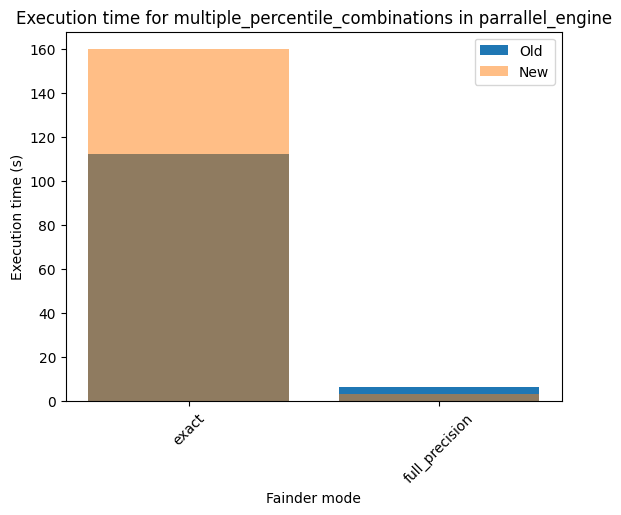

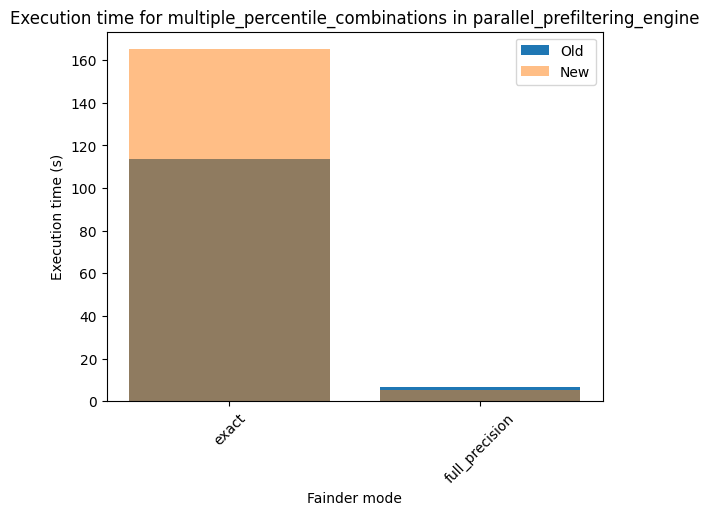

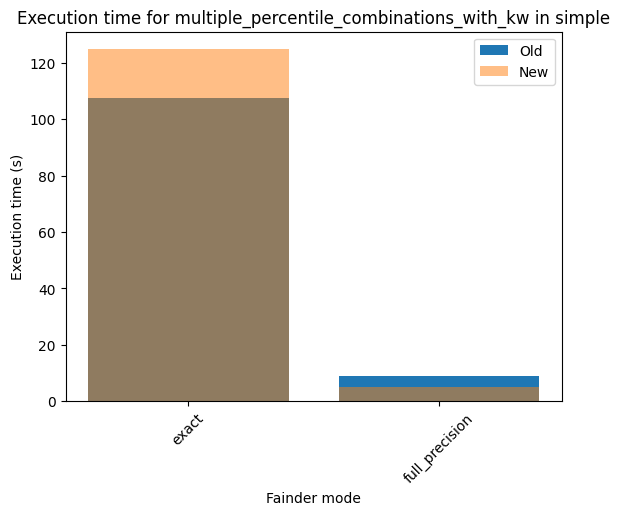

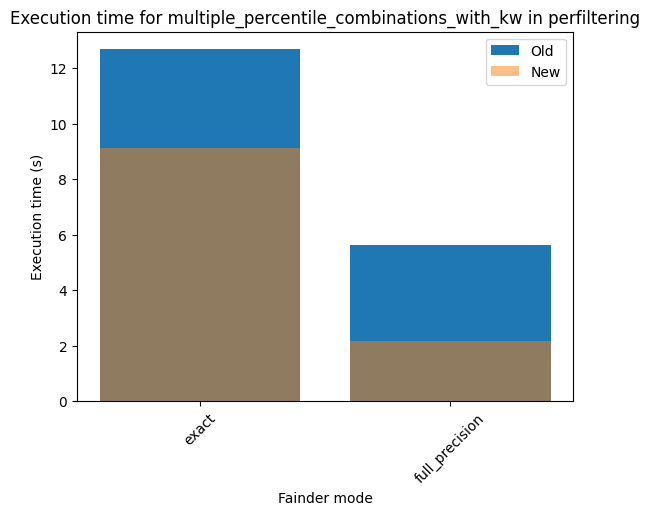

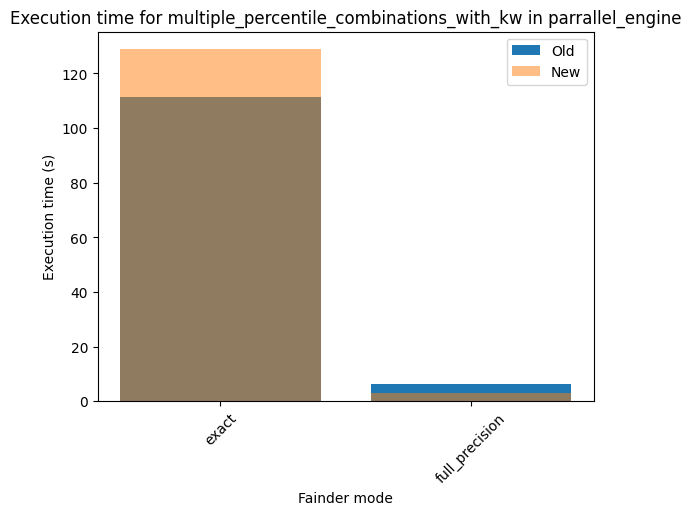

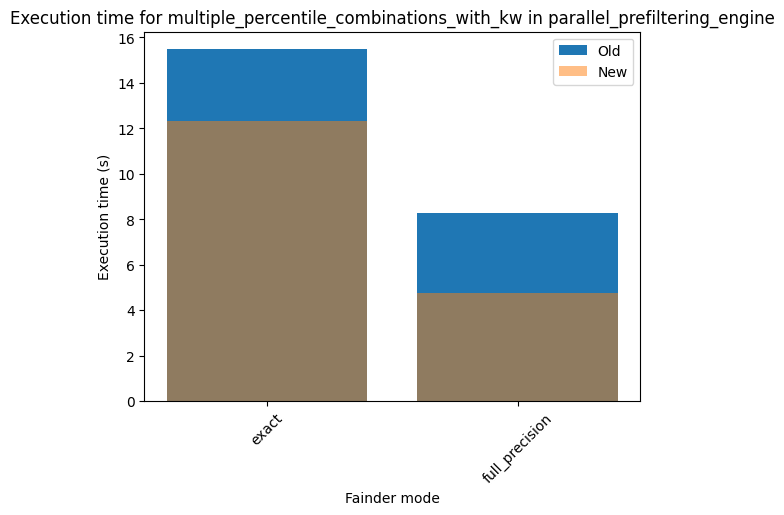

In [25]:
# For each category and fainder_mode (new plot) do a bar plot of the average execution time with scenario on the x-axis

scenarios = df_latest_new["scenario"].unique()
categories = df_latest_new["category"].unique()
fainder_modes = df_latest_new["fainder_mode"].unique()

for category in categories:
    for scenario in scenarios:
        df_latest_new_temp = df_latest_new[
            df_latest_new ["category"] == category
        ]
        df_latest_new_temp = df_latest_new_temp[
            df_latest_new_temp["scenario"] == scenario
        ]
        df_latest_old_temp = df_latest_old[
            df_latest_old["category"] == category
        ]
        df_latest_old_temp = df_latest_old_temp[
            df_latest_old_temp["scenario"] == scenario
        ]
        plt.figure()

        mean_execution_times_new = df_latest_new_temp.groupby("fainder_mode")["execution_time"].mean()

        mean_execution_times_old = df_latest_old_temp.groupby("fainder_mode")["execution_time"].mean()

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_old.values,
        )

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_new.values,
            alpha=0.5,
        )
        plt.title(f"Execution time for {category} in {scenario}")
        plt.xlabel("Fainder mode")
        plt.ylabel("Execution time (s)")

        plt.legend(["Old", "New"])
        plt.xticks(rotation=45)
        





function_info
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/lark.py:637(parse)                             0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/lexer.py:587(match)                            0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/lexer.py:590(next_token)                       0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/lexer.py:661(lex)                              0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/parser_frontends.py:100(parse)                 0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.12/site-packages/lark/parsers/lalr_parser.py:40(parse)               0.000000
/home/leonard/Dokumente/GitHub/fainder-demo-own/backend/.venv/lib/python3.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (22,) and arg 1 with shape (23,).

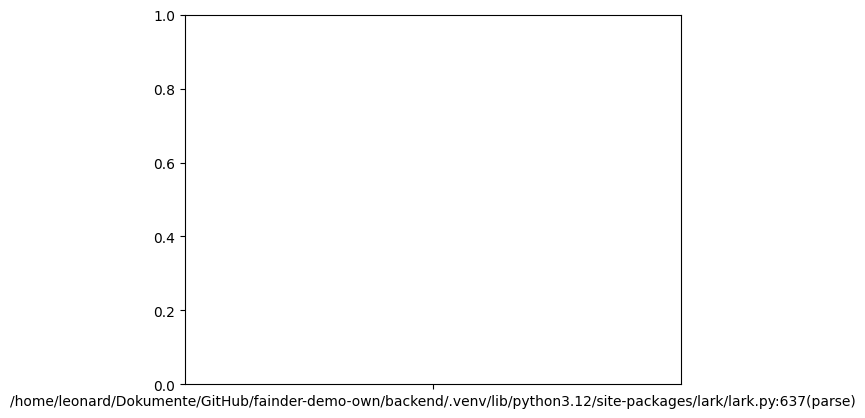

In [26]:
# For each category and fainder_mode (new plot) do a bar plot for profiling data 
# with function_info on the x-axis

for category in categories:
    for scenario in scenarios:
        df_latest_new_temp = df_latest_new_profiling[
            df_latest_new_profiling["category"] == category
        ]
        df_latest_new_temp = df_latest_new_temp[
            df_latest_new_temp["scenario"] == scenario
        ]
        df_latest_old_temp = df_latest_old_profiling[
            df_latest_old_profiling["category"] == category
        ]
        df_latest_old_temp = df_latest_old_temp[
            df_latest_old_temp["scenario"] == scenario
        ]
        plt.figure()

        mean_execution_times_new = (
            df_latest_new_temp.groupby("function_info")["tottime"].mean()
        )

        mean_execution_times_old = (
            df_latest_old_temp.groupby("function_info")["tottime"].mean()
        )

        print(mean_execution_times_new)

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_old.values,
        )

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_new.values,
            alpha=0.5,
        )
        plt.title(f"Execution time for {category} in {scenario}")
        plt.xlabel("Function info")
        plt.ylabel("Execution time (s)")

        plt.legend(["Old", "New"])
        plt.xticks(rotation=45)


